In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist2 = input_data.read_data_sets("/tmp/data/")

X_train = mnist2.train.images
X_test = mnist2.test.images
X_val = mnist2.validation.images

y_train = mnist2.train.labels.astype("int")
y_test = mnist2.test.labels.astype("int")
y_val = mnist2.validation.labels.astype("int")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)
tf.reset_default_graph()
tf.set_random_seed(100)

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'Greys', interpolation="nearest")
    plt.axis("off")
    pass

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


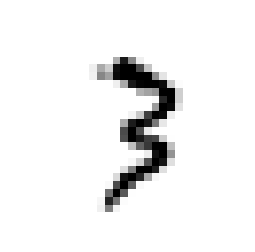

In [2]:
plot_digit(X_train[20000])

In [3]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [4]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# Learning Rate Scheduling

In [5]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    pass

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
    loss = tf.reduce_mean(xentropy, name = 'loss')
    loss_summary = tf.summary.scalar('log_loss', loss)
    pass

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)
    pass

with tf.name_scope('train'):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=True, name = 'global_step')
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum = 0.9)
    training_op = optimizer.minimize(loss, global_step = global_step)
    pass


In [6]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter('/tmp/model/mnist_dnn-rate_scheduling', tf.get_default_graph())

In [7]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            X_batch, y_batch = mnist2.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            pass
        
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], 
                                                                                  feed_dict={X: X_val, y: y_val})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print (epoch+1), "Train accuracy: %.4f, Test accuracy: %.4f" % (acc_train, acc_test)
        pass

    save_path = saver.save(sess, "./model5.ckpt")
    pass

1 Train accuracy: 0.1700, Test accuracy: 0.1615
2 Train accuracy: 0.1690, Test accuracy: 0.1615
3 Train accuracy: 0.1790, Test accuracy: 0.1615
4 Train accuracy: 0.1650, Test accuracy: 0.1615
5 Train accuracy: 0.1550, Test accuracy: 0.1615
6 Train accuracy: 0.1800, Test accuracy: 0.1615
7 Train accuracy: 0.1780, Test accuracy: 0.1615
8 Train accuracy: 0.1750, Test accuracy: 0.1615
9 Train accuracy: 0.1640, Test accuracy: 0.1615
10 Train accuracy: 0.1610, Test accuracy: 0.1615
11 Train accuracy: 0.1670, Test accuracy: 0.1615
12 Train accuracy: 0.1840, Test accuracy: 0.1615
13 Train accuracy: 0.1630, Test accuracy: 0.1615
14 Train accuracy: 0.2010, Test accuracy: 0.1615
15 Train accuracy: 0.1700, Test accuracy: 0.1615
16 Train accuracy: 0.1820, Test accuracy: 0.1615
17 Train accuracy: 0.1740, Test accuracy: 0.1615
18 Train accuracy: 0.1440, Test accuracy: 0.1615
19 Train accuracy: 0.1680, Test accuracy: 0.1615
20 Train accuracy: 0.1700, Test accuracy: 0.1615


In [8]:
with tf.Session() as sess:
    saver.restore(sess, "./model5.ckpt")
    X_new = X_val[:10]
    y_new = y_val[:10]
    Z = logits.eval(session = sess, feed_dict={X: X_new})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./model5.ckpt


In [9]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_new)

('Predicted classes:', array([0, 0, 7, 6, 7, 9, 9, 8, 0, 7]))
('Actual classes:   ', array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))
